## Working with data

In [46]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [47]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
  root ="data",
  train = True,
  download = True,
  transform = ToTensor(),
)

# Download test data from open datasets,
test_data = datasets.FashionMNIST(
  root="data",
  train = False,
  download = True,
  transform=ToTensor(),
)

In [48]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
  print(f"shape of X [N, C, H, W]: {X.shape}")
  print(f"shape of y: {y.shape} {y.type}")
  break


shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
shape of y: torch.Size([64]) <built-in method type of Tensor object at 0x17d15cb40>


## Creating Models

In [49]:
# Get cpu, gpu or mps device for training.
device = (
  "cuda"
  if torch.cuda.is_available()
  else "mps"
  if torch.backends.mps.is_available()
  else "cpu"

)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
      nn.Linear(28*28, 512),
      nn.ReLU(),
      nn.Linear(512, 512),
      nn.ReLU(),
      nn.Linear(512,10)
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits
  
model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Optimizing the Model Parameters

In [50]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [51]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [52]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [53]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.303643  [   64/60000]
loss: 2.293945  [ 6464/60000]
loss: 2.280457  [12864/60000]
loss: 2.265203  [19264/60000]
loss: 2.255441  [25664/60000]
loss: 2.229511  [32064/60000]
loss: 2.227628  [38464/60000]
loss: 2.206151  [44864/60000]
loss: 2.196387  [51264/60000]
loss: 2.154268  [57664/60000]
Test Error: 
 Accuracy: 47.6%, Avg loss: 2.166437 

Epoch 2
-------------------------------
loss: 2.180491  [   64/60000]
loss: 2.173079  [ 6464/60000]
loss: 2.123580  [12864/60000]
loss: 2.122919  [19264/60000]
loss: 2.086372  [25664/60000]
loss: 2.026135  [32064/60000]
loss: 2.044775  [38464/60000]
loss: 1.983426  [44864/60000]
loss: 1.977143  [51264/60000]
loss: 1.893721  [57664/60000]
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.911402 

Epoch 3
-------------------------------
loss: 1.950596  [   64/60000]
loss: 1.922688  [ 6464/60000]
loss: 1.814858  [12864/60000]
loss: 1.832815  [19264/60000]
loss: 1.740941  [25664/60000]
loss: 1.685168  [32064/600

## Saving Models

In [54]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## Loading Models

In [55]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [56]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')




Predicted: "Ankle boot", Actual: "Ankle boot"


## Tensors: what are these and how to use them?

In [57]:
import numpy as np

### Initializing a Tensor

In [58]:
# Directly from data
data = [[1,2], [3,4]]
x_data = torch.tensor(data)

In [59]:
# From a Numpy array
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

In [60]:
# From another tensor:
x_ones = torch.ones_like(x_data) # retains the properties of x_data
print(f"Ones Tensor: \n {x_ones} \n")
x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides the datatype of x_data
print(f"Random Tensor: \n {x_rand} \n")

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.3113, 0.7818],
        [0.1021, 0.4849]]) 



In [61]:
#With random or constant values:
shape = (2, 3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")



Random Tensor: 
 tensor([[0.6078, 0.2804, 0.2838],
        [0.6219, 0.1621, 0.0458]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


In [62]:
# Tensor Attributes
tensor = torch.rand(3, 4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


In [63]:
# Tensor Operations
# We move our tensor to the GPU if available
if torch.cuda.is_available():
  tensor = tensor.to('cuda')
  print(f"Device tensor is stored on: {tensor.device}")


In [64]:
# Standard numpy-like indexing and slicing:
tensor = torch.ones(4, 4)
tensor[:,1] = 0
print(tensor)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


##### To join tensors, we can use torch.cat to concatenate a sequence of tensors along a specified dimension. Another tensor joining operation, torch.stack, is similar but subtly different from torch.cat.

In [65]:
t1 = torch.cat([tensor, tensor, tensor], dim=1)
print(t1)

tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]])


In [66]:
# Multiplying Tensors
# This computes the element-wise product
print(f"tensor.mul(tensor) \n {tensor.mul(tensor)} \n")
# Alternative syntax:
print(f"tensor * tensor \n {tensor * tensor}")


tensor.mul(tensor) 
 tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

tensor * tensor 
 tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


##### This computes the matrix multiplication between two tensors

In [67]:
print(f"tensor.matmul(tensor.T) \n {tensor.matmul(tensor.T)} \n")
# Alternative syntax:
print(f"tensor @ tensor.T \n {tensor @ tensor.T}")

tensor.matmul(tensor.T) 
 tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]]) 

tensor @ tensor.T 
 tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])


##### **In-place operations** Operations that have a _ suffix are in-place. For example: x.copy_(Y), x.t_(), will change x.

In [68]:
print(tensor, "\n")
tensor.add_(5)
print(tensor)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

tensor([[6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.]])


### Datasets & DataLoaders

### Iterating and Visualizing the Dataset

In [70]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

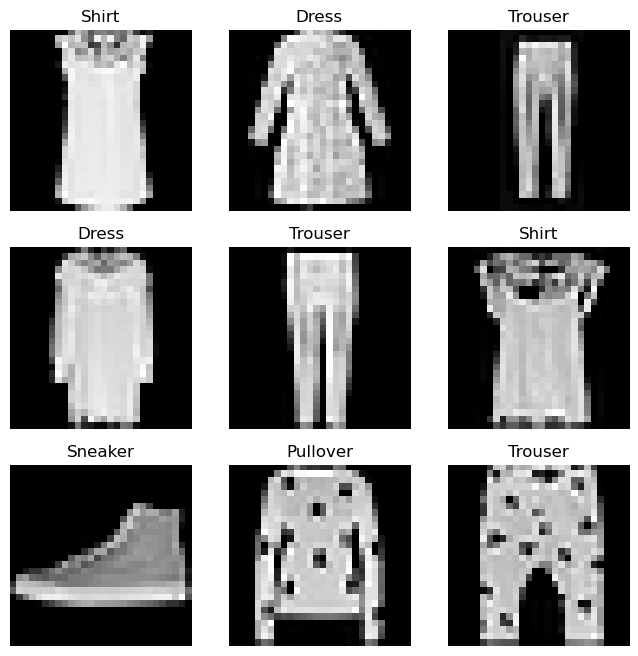

In [71]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Creating a Custom Dataset for your files

In [72]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### __ init __

The __init__ is a special function used to set up newly created objects. It's part of a class definition and runs automatically when creating a new instance of the class.

##### The labels.csv file looks like:

In [80]:
# tshirt1.jpg, 0
# tshirt2.jpg, 0

# ankleboot999.jpg, 9

In [74]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

####  __ len __

 __ len __ is a special method that defines how the len() function behaves for class instances. Implementing __ len __ in your class enables objects to be passed to len(), returning an integer representing the object's size or number of elements.

In [76]:
# Example
def __len__(self):
    return len(self.img_labels)

### __ getitem __

The __getitem__ method in Python is a special function that defines how elements are accessed using square brackets ([]). Implementing __getitem__ in your class enables instances to support indexing and slicing, similar to built-in data structures like lists, tuples, and dictionaries.

In [77]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label


### Preparing your data for training with DataLoaders

In [78]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

### Iterate through the Dataloader

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


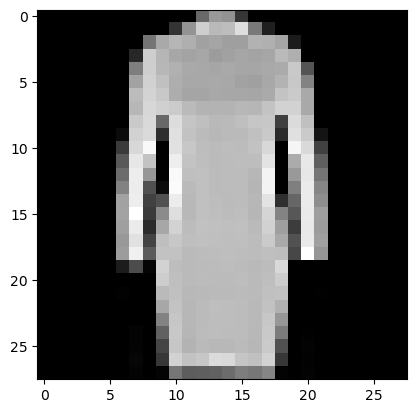

Label: 3


In [79]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

### Transforms

##### Data often requires preprocessing before it's suitable for training machine learning algorithms. Transforms help manipulate the data into the appropriate format.

TorchVision datasets include two parameters: 'transform' for modifying features and 'target_transform' for altering labels. These accept callables containing transformation logic. The torchvision.transforms module provides many ready-to-use transforms.

FashionMNIST features are in PIL Image format with integer labels. For training, we need normalized tensor features and one-hot encoded tensor labels. We use ToTensor and Lambda transforms to achieve these conversions.

In [81]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

### To Tensor()

In [ ]:
#ToTensor converts a PIL image or NumPy ndarray into a FloatTensor. and scales the image’s pixel intensity values in the range [0., 1.]

### Lambda Transforms

In PyTorch, Lambda transforms apply custom, user-defined transformations to data within the torchvision.transforms module. This feature offers flexibility for preprocessing steps not covered by torchvision's standard transformations. The Lambda transform takes a function as an argument and applies it to each dataset element.

In [82]:
target_transform = Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))

### Build the Neural Network

### A  neural network consists of interconnected nodes (neurons) that process and learn from data through weighted connections. 

In [83]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

##### `torch.nn` is a module in PyTorch that provides essential tools for building and training neural networks. It includes pre-defined layers, loss functions, and utilities to streamline the creation, customization, and optimization of deep learning models.

### Get Device for Training

In [84]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


### Define the Class

In [85]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [86]:
# Build the model
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [87]:
# Forward pass
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([8])


### Model Layers

##### Let’s break down the layers in the FashionMNIST model. To illustrate it, we will take a sample minibatch of 3 images of size 28x28 and see what happens to it as we pass it through the network

In [88]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


### nn.Flatten, nn.Linear, nn.ReLU, nn.Sequential, nn.Softmax

nn.Flatten converts multi-dimensional input tensors into 1-dimensional tensors in neural networks, particularly in PyTorch.

nn.Linear, also called a fully connected or dense layer, is a key component in neural networks. It performs linear transformations on input data, mapping it to an output space.

nn.ReLU (Rectified Linear Unit) is a popular activation function that introduces non-linearity into neural networks, essential for learning complex patterns.

nn.Sequential is a PyTorch container module that allows stacking layers in order, useful for building simple feed-forward neural networks where each layer's output becomes the next layer's input.

nn.Softmax is an activation function used in the final layer of classification models. It transforms raw output scores (logits) into probabilities, making them easier to interpret and use for decision-making.

In [90]:
flatten =  nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())
#nn.Linear 
layer1 = nn.Linear (in_features=28*28, out_features = 20)
hidden1 = layer1(flat_image)
print(hidden1.size())
#nn.ReLU 
print(f"Before ReLU:  {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")
#nn.Sequential 
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)
#nn.Softmax
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

torch.Size([3, 784])
torch.Size([3, 20])
Before ReLU:  tensor([[-0.3264,  0.2045, -0.2844, -0.4914, -0.1212,  0.0925, -0.5322, -0.4351,
          0.0932,  0.3811, -0.0162,  0.0242, -0.5544,  0.7543,  0.3187, -0.1645,
          0.5500,  0.6467,  0.1858,  0.0836],
        [-0.0144,  0.4569, -0.6450, -0.4188, -0.4306,  0.4422, -0.4905, -0.3342,
          0.3966,  0.1537,  0.3626,  0.3200, -0.3123,  0.6153,  0.3389, -0.3378,
          0.5751,  0.7267,  0.5071,  0.3118],
        [-0.1139,  0.3702, -0.2975, -0.4764,  0.0751,  0.3665, -0.4987, -0.4759,
          0.2069,  0.3965, -0.2714,  0.1578, -0.3417,  0.4921,  0.0848, -0.3314,
          0.5995,  0.5459,  0.1521,  0.1647]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.0000, 0.2045, 0.0000, 0.0000, 0.0000, 0.0925, 0.0000, 0.0000, 0.0932,
         0.3811, 0.0000, 0.0242, 0.0000, 0.7543, 0.3187, 0.0000, 0.5500, 0.6467,
         0.1858, 0.0836],
        [0.0000, 0.4569, 0.0000, 0.0000, 0.0000, 0.4422, 0.0000, 0.0000, 0.3966,
         0.

### Model Parameters

In [91]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
  print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[ 0.0222,  0.0123, -0.0129,  ..., -0.0325, -0.0223, -0.0179],
        [-0.0140,  0.0023,  0.0340,  ..., -0.0356,  0.0184, -0.0194]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0051,  0.0109], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[-0.0049,  0.0060,  0.0289,  ..., -0.0018,  0.0399, -0.0032],
        [ 0.0007,  0.0043,  0.0098,  ..., -0.0324, -0.0035,  0.0187]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | 

### Automatic Differentiation with torch.autograd

In [2]:
import torch
x = torch.ones(5) # input tensor
y = torch.zeros(3) # expected output
w = torch.randn(5, 3, requires_grad= True)
b = torch.randn(3, requires_grad = True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

In [3]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x308fff850>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x309329d50>


### Computing Gradients

In [4]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.1705, 0.2581, 0.0210],
        [0.1705, 0.2581, 0.0210],
        [0.1705, 0.2581, 0.0210],
        [0.1705, 0.2581, 0.0210],
        [0.1705, 0.2581, 0.0210]])
tensor([0.1705, 0.2581, 0.0210])


Note

 We can only obtain the grad properties for the leaf nodes of the computational graph, which have requires_grad property set to True. For all other nodes in our graph, gradients will not be available.

We can only perform gradient calculations using backward once on a given graph, for performance reasons. If we need to do several backward calls on the same graph, we need to pass retain_graph=True to the backward call.

### Disabling Gradient Tracking

By default, all tensors with requires_grad=True track their computational history and support gradient computation. However, in some cases, such as when applying a trained model to input data, we only need forward computations through the network. To stop tracking computations, we can wrap our code in a torch.no_grad() block.

In [5]:
z = torch.matmul(x,w)+b
print(z.requires_grad)

with torch.no_grad():
  z = torch.matmul(x,w)+b
print(z.requires_grad)

True
False


In [6]:
# Another way to achieve the same result is to use the detach() method on the tensor:
z = torch.matmul(x,w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


### Optional Reading: Tensor Gradients and Jacobian Products

In [7]:
inp = torch.eye(4, 5, requires_grad=True)
out = (inp+1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"First call\n{inp.grad}")
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")
inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


### Optimizing Model Parameters

In [9]:
# Prerequisite Code
# we load the code from the previous sections on Datasets and Data Loaders and Build Model.
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

### Hyperparameters

In [10]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

### Loss Function

In [11]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

### Optimizer

In [12]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Full Implementation
We define train_loop that loops over our optimization code, and test_loop that evaluates the model’s performance against our test data.

In [15]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

We initialize the loss function and optimizer, and pass it to train_loop and test_loop. Feel free to increase the number of epochs to track the model’s improving performance.

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.301539  [   64/60000]
loss: 2.289985  [ 6464/60000]
loss: 2.278532  [12864/60000]
loss: 2.271997  [19264/60000]
loss: 2.235570  [25664/60000]
loss: 2.215268  [32064/60000]
loss: 2.213233  [38464/60000]
loss: 2.177849  [44864/60000]
loss: 2.176032  [51264/60000]
loss: 2.145626  [57664/60000]
Test Error: 
 Accuracy: 50.6%, Avg loss: 2.138972 

Epoch 2
-------------------------------
loss: 2.147517  [   64/60000]
loss: 2.137679  [ 6464/60000]
loss: 2.080538  [12864/60000]
loss: 2.096019  [19264/60000]
loss: 2.030731  [25664/60000]
loss: 1.976007  [32064/60000]
loss: 1.994684  [38464/60000]
loss: 1.913609  [44864/60000]
loss: 1.914102  [51264/60000]
loss: 1.844186  [57664/60000]
Test Error: 
 Accuracy: 57.7%, Avg loss: 1.842278 

Epoch 3
-------------------------------
loss: 1.878593  [   64/60000]
loss: 1.849953  [ 6464/60000]
loss: 1.727505  [12864/60000]
loss: 1.766215  [19264/60000]
loss: 1.652912  [25664/60000]
loss: 1.612660  [32064/600

### Save and Load the Model
In this section we will look at how to persist model state with saving, loading and running model predictions.



In [19]:
import torch
import torchvision.models as models

### Saving and Loading Model Weights

PyTorch models store the learned parameters in an internal state dictionary, called state_dict. These can be persisted via the torch.save method:



In [20]:
model = models.vgg16(weights='IMAGENET1K_V1')
torch.save(model.state_dict(), 'model_weights.pth')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/anjalisuman/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 85.7MB/s] 


To load model weights, you need to create an instance of the same model first, and then load the parameters using load_state_dict() method.

In the code below, we set weights_only=True to limit the functions executed during unpickling to only those necessary for loading weights. Using weights_only=True is considered a best practice when loading weights.

In [21]:
model = models.vgg16() # we do not specify ``weights``, i.e. create untrained model
model.load_state_dict(torch.load('model_weights.pth', weights_only=True))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

NOTE:
be sure to call model.eval() method before inferencing to set the dropout and batch normalization layers to evaluation mode. Failing to do this will yield inconsistent inference results.

### Saving and Loading Models with Shapes

When loading model weights, we needed to instantiate the model class first, because the class defines the structure of a network. We might want to save the structure of this class together with the model, in which case we can pass model (and not model.state_dict()) to the saving function:

In [22]:
torch.save(model, 'model.pth')


We can then load the model as demonstrated below.

As described in Saving and loading torch.nn.Modules, saving state_dict``s is considered the best practice. However, below we use ``weights_only=False because this involves loading the model, which is a legacy use case for torch.save.

In [23]:
model = torch.load('model.pth', weights_only=False),

Note: 
This approach uses Python pickle module when serializing the model, thus it relies on the actual class definition to be available when loading the model.